In [1]:
import joblib
import numpy as np
import os
import math
import csv
from skimage.measure import compare_ssim as ssim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from PIL import Image
import matplotlib.pyplot as plt # to plot images
%matplotlib inline
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, merge, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


### Consts

In [2]:
train_and_val_dataset_file = 'dataset/dataset-1/train-and-valenh.pkl'
test_dataset_file = 'dataset/dataset-1/testenh.pkl'
augmented_train_dataset_save_file = 'dataset/dataset-1/train-augmentedenh-11496.pkl'
# saved_model_filename = "dataset/dataset-1/test-3-{epoch:02d}-{val_dice_coef_accur:.4f}.hdf5"
# saved_model_filename = "dataset/dataset-1/test-12-{epoch:02d}-{IOU_calc:.4f}.hdf5"
# saved_model_filename = "dataset/dataset-1/test-5-{epoch:02d}-{val_acc:.4f}.hdf5"
saved_model_filename = "dataset/dataset-1/testenh-1-{epoch:02d}-{val_dice_coef_accur:.4f}.hdf5"

csv_logger_training = "dataset/dataset-1/testenh-1.csv"
result_imgs_folder = 'results/test-14/{}_{}.tiff'

In [3]:
#Checking if GPU is running
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


X_remaining, Y_remaining, remaining_dataset_desc = joblib.load(train_and_val_dataset_file)
Xte, yte, test_dataset_desc = joblib.load(test_dataset_file) # X and y for test
training_set_index = remaining_dataset_desc['training_set_index']
validation_set_index = remaining_dataset_desc['validation_set_index']

Xtr, ytr = X_remaining[:training_set_index,:], Y_remaining[:training_set_index] # X and y for training
Xva, yva = X_remaining[training_set_index:validation_set_index,:], Y_remaining[training_set_index:validation_set_index] # X and y for validation

print(Xtr.shape)
print(Xva.shape)
print(Xte.shape)
print(ytr.shape)
print(yva.shape)
print(yte.shape)

Xtr, ytr = joblib.load(augmented_train_dataset_save_file)
print(Xtr.shape)
print(ytr.shape)

Default GPU Device: /device:GPU:0
(1437, 128, 128, 1)
(205, 128, 128, 1)
(412, 128, 128, 1)
(1437, 128, 128, 1)
(205, 128, 128, 1)
(412, 128, 128, 1)
(12933, 128, 128, 1)
(12933, 128, 128, 1)


### Pre processing

In [4]:
# Preprocessing in the training set (mean and sd) and apply it to all sets

full_image_mean_value = Xtr.mean() # mean-value for each pixel of all full images
full_image_sd = Xtr.std() # standard deviation for each pixel of all full images

Xtr = (Xtr - full_image_mean_value) / full_image_sd
Xva = (Xva - full_image_mean_value) / full_image_sd
Xte = (Xte - full_image_mean_value) / full_image_sd

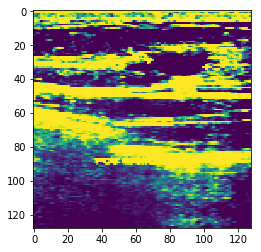

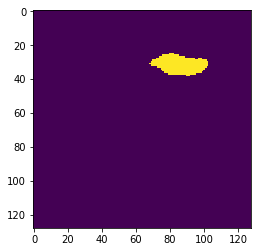

In [5]:
#Conferir alguma imagem
indice = 17
plt.imshow(Xva[indice].reshape((128,128)))
plt.show()
plt.imshow(yva[indice].reshape((128,128)))
plt.show()

### Pre-configurations

In [6]:
K.set_image_data_format('channels_last')  # TF dimension
_, *input_image_shape, _ = Xtr.shape
input_image_shape = tuple(input_image_shape)
print(input_image_shape)

smooth = 1
use_dropout = True
use_regularizers = True
dropout_rate = 0.5
number_of_epochs = 1000
batch_size = 32
kernel_size = (3, 3)
initial_volume_size = 64

(128, 128)


### Define Unet model

In [7]:
# Define loss function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = 2 * K.sum(y_true_f * y_pred_f) + smooth
    union = K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    return K.mean(intersection / union)

def dice_coef_per_image_in_batch(y_true, y_pred):
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = 2 * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
    union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
    return K.mean(intersection / union)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef_per_image_in_batch(y_true, y_pred)

def dice_coef_accur(y_true, y_pred):
    return dice_coef_per_image_in_batch(y_true, y_pred)
#     y_true_f = K.flatten(y_true)
#     y_pred_f = K.flatten(y_pred)
#     y_pred_f = K.cast(  K.greater_equal(y_pred_f, 0.5)  , tf.float32)
#     accuracy = tf.equal(y_true_f, y_pred_f)
#     return accuracy
    
def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

def f1_score(y_true, y_pred):
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))
    if c3 == 0:
        return 0

    precision = c1 / c2
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return - K.mean(f1)

def setup_regularizers(conv_layer):
    return BatchNormalization()(conv_layer) if use_regularizers else conv_layer
    
def setup_dropout(conv_layer):
    return Dropout(dropout_rate)(conv_layer) if use_dropout else conv_layer

# Define model
# from keras.layers.advanced_activations import PReLU
# inputs = Input((*input_image_shape, 1))
# conv1 = Conv2D(initial_volume_size, kernel_size, padding='same')(inputs)
# conv1 = PReLU()(conv1)
# conv1 = Conv2D(initial_volume_size, kernel_size, padding='same')(conv1)
# conv1 = PReLU()(conv1)
# conv1 = setup_regularizers(conv1)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# conv2 = Conv2D(initial_volume_size*2, kernel_size, padding='same')(pool1)
# conv2 = PReLU()(conv2)
# conv2 = Conv2D(initial_volume_size*2, kernel_size, padding='same')(conv2)
# conv2 = PReLU()(conv2)
# conv2 = setup_regularizers(conv2)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# conv3 = Conv2D(initial_volume_size*4, kernel_size, padding='same')(pool2)
# conv3 = PReLU()(conv3)
# conv3 = Conv2D(initial_volume_size*4, kernel_size, padding='same')(conv3)
# conv3 = PReLU()(conv3)
# conv3 = setup_regularizers(conv3)
# pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# conv4 = Conv2D(initial_volume_size*8, kernel_size, padding='same')(pool3)
# conv4 = PReLU()(conv4)
# conv4 = Conv2D(initial_volume_size*8, kernel_size, padding='same')(conv4)
# conv4 = PReLU()(conv4)
# conv4 = setup_regularizers(conv4)
# pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# conv5 = Conv2D(initial_volume_size*16, kernel_size, padding='same')(pool4)
# conv5 = PReLU()(conv5)
# conv5 = Conv2D(initial_volume_size*16, kernel_size, padding='same')(conv5)
# conv5 = PReLU()(conv5)
# conv5 = setup_regularizers(conv5)

# up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
# up6 = setup_dropout(up6)
# conv6 = Conv2D(initial_volume_size*8, kernel_size, padding='same')(up6)
# conv6 = PReLU()(conv6)
# conv6 = Conv2D(initial_volume_size*8, kernel_size, padding='same')(conv6)
# conv6 = PReLU()(conv6)

# up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
# up7 = setup_dropout(up7)
# conv7 = Conv2D(initial_volume_size*4, kernel_size, padding='same')(up7)
# conv7 = PReLU()(conv7)
# conv7 = Conv2D(initial_volume_size*4, kernel_size, padding='same')(conv7)
# conv7 = PReLU()(conv7)

# up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
# up8 = setup_dropout(up8)
# conv8 = Conv2D(initial_volume_size*2, kernel_size, padding='same')(up8)
# conv8 = PReLU()(conv8)
# conv8 = Conv2D(initial_volume_size*2, kernel_size, padding='same')(conv8)
# conv8 = PReLU()(conv8)

# up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
# up9 = setup_dropout(up9)
# conv9 = Conv2D(initial_volume_size, kernel_size, padding='same')(up9)
# conv9 = PReLU()(conv9)
# conv9 = Conv2D(initial_volume_size, kernel_size, padding='same')(conv9)
# conv9 = PReLU()(conv9)

# conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) #sigmoid/softmax
inputs = Input((*input_image_shape, 1))
conv1 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(inputs)
conv1 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(conv1)
conv1 = setup_regularizers(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(pool1)
conv2 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(conv2)
conv2 = setup_regularizers(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(pool2)
conv3 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(conv3)
conv3 = setup_regularizers(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(pool3)
conv4 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(conv4)
conv4 = setup_regularizers(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(initial_volume_size*16, kernel_size, activation='relu', padding='same')(pool4)
conv5 = Conv2D(initial_volume_size*16, kernel_size, activation='relu', padding='same')(conv5)
conv5 = setup_regularizers(conv5)

up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
up6 = setup_dropout(up6)
conv6 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(up6)
conv6 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(conv6)

up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
up7 = setup_dropout(up7)
conv7 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(up7)
conv7 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(conv7)

up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
up8 = setup_dropout(up8)
conv8 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(up8)
conv8 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(conv8)

up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
up9 = setup_dropout(up9)
conv9 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(up9)
conv9 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) #sigmoid/softmax
model = Model(inputs=[inputs], outputs=[conv10])



model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=['accuracy', dice_coef_accur, IOU_calc, f1_score])
# model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=['accuracy'])
# model.compile(optimizer=Adam(lr=1e-5), loss=IOU_calc_loss, metrics=['accuracy', dice_coef_accur, IOU_calc, f1_score])
# model.compile(optimizer=Adam(lr=1e-5), loss = 'binary_crossentropy', metrics=['accuracy', dice_coef_accur, IOU_calc, f1_score])
# model.compile(optimizer=Adam(lr=1e-5), loss='mean_squared_error',  metrics=['accuracy'])
# model.compile(loss='hinge', optimizer=Adam(lr=1e-5), metrics=['accuracy'])

# Options for the mode
print("Size of the CNN: %s" % model.count_params())
#model.load_weights("dataset/dataset-1/test-3-02-0.7472.hdf5")
#model.load_weights("dataset/dataset-1/test-4-01-0.6881.hdf5")
#model.load_weights("dataset/dataset-1/test-5-10-0.9667.hdf5")
# model.load_weights("dataset/dataset-1/test-6-91-0.9785.hdf5")
# model.load_weights("dataset/dataset-1/test-7-58-0.9767.hdf5")
# model.load_weights("dataset/dataset-1/test-8-10-0.9800.hdf5""))
# model.load_weights("dataset/dataset-1/test-9-07-0.9618.hdf5")
# model.load_weights("dataset/dataset-1/test-10-912-0.8516.hdf5")
# model.load_weights("dataset/dataset-1/test-11-572-0.8587.hdf5")
# model.load_weights("dataset/dataset-1/test-12-846-0.8519.hdf5")
# model.load_weights("dataset/dataset-1/test-13-312-0.8595.hdf5")
# model.load_weights("dataset/dataset-1/test-14-1395-0.8196.hdf5")
model.load_weights("dataset/dataset-1/testenh-1-352-0.8370.hdf5")

Size of the CNN: 31385729


In [8]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 64) 256         conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

### Train model

In [ ]:
# Define callbacks
model_checkpoint = ModelCheckpoint(saved_model_filename, monitor='val_dice_coef_accur', save_best_only=True, verbose=1)
# model_checkpoint = ModelCheckpoint(saved_model_filename, monitor='IOU_calc', save_best_only=True, verbose=1)
# model_checkpoint = ModelCheckpoint(saved_model_filename, monitor='val_acc', save_best_only=True, verbose=1)

csv_logger = CSVLogger(csv_logger_training, append=True, separator=';')

# Train
history = model.fit(Xtr, ytr, batch_size=batch_size, epochs=number_of_epochs, verbose=1, shuffle=True,
             callbacks=[model_checkpoint, csv_logger], validation_data=(Xva, yva))

Train on 12933 samples, validate on 205 samples
Epoch 1/1000
12933/12933 [==============================] - 125s 10ms/step - loss: -0.6649 - acc: 0.8816 - dice_coef_accur: 0.6649 - IOU_calc: 0.6928 - f1_score: 0.6979 - val_loss: -0.7555 - val_acc: 0.9655 - val_dice_coef_accur: 0.7555 - val_IOU_calc: 0.7970 - val_f1_score: 0.7983

Epoch 00001: val_dice_coef_accur improved from -inf to 0.75554, saving model to dataset/dataset-1/testenh-1-01-0.7555.hdf5
Epoch 2/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.8409 - acc: 0.9539 - dice_coef_accur: 0.8409 - IOU_calc: 0.8519 - f1_score: 0.8504 - val_loss: -0.7804 - val_acc: 0.9697 - val_dice_coef_accur: 0.7804 - val_IOU_calc: 0.8218 - val_f1_score: 0.8226

Epoch 00002: val_dice_coef_accur improved from 0.75554 to 0.78037, saving model to dataset/dataset-1/testenh-1-02-0.7804.hdf5
Epoch 3/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.8804 - acc: 0.9590 - dice_coef_accur: 0.8804 - IOU_


Epoch 00045: val_dice_coef_accur did not improve from 0.82649
Epoch 46/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9698 - acc: 0.9688 - dice_coef_accur: 0.9698 - IOU_calc: 0.9750 - f1_score: 0.9713 - val_loss: -0.8254 - val_acc: 0.9769 - val_dice_coef_accur: 0.8254 - val_IOU_calc: 0.8593 - val_f1_score: 0.8593

Epoch 00046: val_dice_coef_accur did not improve from 0.82649
Epoch 47/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9702 - acc: 0.9688 - dice_coef_accur: 0.9702 - IOU_calc: 0.9754 - f1_score: 0.9718 - val_loss: -0.8180 - val_acc: 0.9756 - val_dice_coef_accur: 0.8180 - val_IOU_calc: 0.8557 - val_f1_score: 0.8557

Epoch 00047: val_dice_coef_accur did not improve from 0.82649
Epoch 48/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9704 - acc: 0.9688 - dice_coef_accur: 0.9704 - IOU_calc: 0.9757 - f1_score: 0.9720 - val_loss: -0.8134 - val_acc: 0.9752 - val_dice_coef_accur: 0.8134 - val_IO


Epoch 00068: val_dice_coef_accur did not improve from 0.83136
Epoch 69/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9740 - acc: 0.9689 - dice_coef_accur: 0.9740 - IOU_calc: 0.9789 - f1_score: 0.9754 - val_loss: -0.8283 - val_acc: 0.9775 - val_dice_coef_accur: 0.8283 - val_IOU_calc: 0.8654 - val_f1_score: 0.8654

Epoch 00069: val_dice_coef_accur did not improve from 0.83136
Epoch 70/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9741 - acc: 0.9689 - dice_coef_accur: 0.9741 - IOU_calc: 0.9791 - f1_score: 0.9755 - val_loss: -0.8264 - val_acc: 0.9768 - val_dice_coef_accur: 0.8264 - val_IOU_calc: 0.8611 - val_f1_score: 0.8611

Epoch 00070: val_dice_coef_accur did not improve from 0.83136
Epoch 71/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9743 - acc: 0.9689 - dice_coef_accur: 0.9743 - IOU_calc: 0.9792 - f1_score: 0.9757 - val_loss: -0.8318 - val_acc: 0.9774 - val_dice_coef_accur: 0.8318 - val_IO


Epoch 00091: val_dice_coef_accur did not improve from 0.83667
Epoch 92/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9767 - acc: 0.9690 - dice_coef_accur: 0.9767 - IOU_calc: 0.9811 - f1_score: 0.9777 - val_loss: -0.8265 - val_acc: 0.9771 - val_dice_coef_accur: 0.8265 - val_IOU_calc: 0.8596 - val_f1_score: 0.8596

Epoch 00092: val_dice_coef_accur did not improve from 0.83667
Epoch 93/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9769 - acc: 0.9690 - dice_coef_accur: 0.9769 - IOU_calc: 0.9810 - f1_score: 0.9775 - val_loss: -0.8308 - val_acc: 0.9773 - val_dice_coef_accur: 0.8308 - val_IOU_calc: 0.8629 - val_f1_score: 0.8629

Epoch 00093: val_dice_coef_accur did not improve from 0.83667
Epoch 94/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9770 - acc: 0.9690 - dice_coef_accur: 0.9770 - IOU_calc: 0.9812 - f1_score: 0.9778 - val_loss: -0.8309 - val_acc: 0.9774 - val_dice_coef_accur: 0.8309 - val_IO


Epoch 00138: val_dice_coef_accur did not improve from 0.83667
Epoch 139/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9814 - acc: 0.9691 - dice_coef_accur: 0.9814 - IOU_calc: 0.9841 - f1_score: 0.9809 - val_loss: -0.8325 - val_acc: 0.9781 - val_dice_coef_accur: 0.8325 - val_IOU_calc: 0.8677 - val_f1_score: 0.8676

Epoch 00139: val_dice_coef_accur did not improve from 0.83667
Epoch 140/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9814 - acc: 0.9691 - dice_coef_accur: 0.9814 - IOU_calc: 0.9841 - f1_score: 0.9809 - val_loss: -0.8287 - val_acc: 0.9779 - val_dice_coef_accur: 0.8287 - val_IOU_calc: 0.8664 - val_f1_score: 0.8664

Epoch 00140: val_dice_coef_accur did not improve from 0.83667
Epoch 141/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9815 - acc: 0.9691 - dice_coef_accur: 0.9815 - IOU_calc: 0.9842 - f1_score: 0.9810 - val_loss: -0.8338 - val_acc: 0.9782 - val_dice_coef_accur: 0.8338 - val


Epoch 00185: val_dice_coef_accur did not improve from 0.83667
Epoch 186/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9831 - acc: 0.9692 - dice_coef_accur: 0.9831 - IOU_calc: 0.9856 - f1_score: 0.9826 - val_loss: -0.8269 - val_acc: 0.9777 - val_dice_coef_accur: 0.8269 - val_IOU_calc: 0.8629 - val_f1_score: 0.8629

Epoch 00186: val_dice_coef_accur did not improve from 0.83667
Epoch 187/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9831 - acc: 0.9692 - dice_coef_accur: 0.9831 - IOU_calc: 0.9857 - f1_score: 0.9827 - val_loss: -0.8314 - val_acc: 0.9782 - val_dice_coef_accur: 0.8314 - val_IOU_calc: 0.8668 - val_f1_score: 0.8668

Epoch 00187: val_dice_coef_accur did not improve from 0.83667
Epoch 188/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9832 - acc: 0.9692 - dice_coef_accur: 0.9832 - IOU_calc: 0.9857 - f1_score: 0.9828 - val_loss: -0.8277 - val_acc: 0.9776 - val_dice_coef_accur: 0.8277 - val


Epoch 00232: val_dice_coef_accur did not improve from 0.83667
Epoch 233/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9842 - acc: 0.9692 - dice_coef_accur: 0.9842 - IOU_calc: 0.9867 - f1_score: 0.9839 - val_loss: -0.8256 - val_acc: 0.9780 - val_dice_coef_accur: 0.8256 - val_IOU_calc: 0.8632 - val_f1_score: 0.8632

Epoch 00233: val_dice_coef_accur did not improve from 0.83667
Epoch 234/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9843 - acc: 0.9692 - dice_coef_accur: 0.9843 - IOU_calc: 0.9867 - f1_score: 0.9839 - val_loss: -0.8282 - val_acc: 0.9780 - val_dice_coef_accur: 0.8282 - val_IOU_calc: 0.8649 - val_f1_score: 0.8649

Epoch 00234: val_dice_coef_accur did not improve from 0.83667
Epoch 235/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9844 - acc: 0.9692 - dice_coef_accur: 0.9844 - IOU_calc: 0.9868 - f1_score: 0.9840 - val_loss: -0.8281 - val_acc: 0.9780 - val_dice_coef_accur: 0.8281 - val


Epoch 00279: val_dice_coef_accur did not improve from 0.83667
Epoch 280/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9853 - acc: 0.9692 - dice_coef_accur: 0.9853 - IOU_calc: 0.9875 - f1_score: 0.9850 - val_loss: -0.8243 - val_acc: 0.9786 - val_dice_coef_accur: 0.8243 - val_IOU_calc: 0.8678 - val_f1_score: 0.8678

Epoch 00280: val_dice_coef_accur did not improve from 0.83667
Epoch 281/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9852 - acc: 0.9692 - dice_coef_accur: 0.9852 - IOU_calc: 0.9875 - f1_score: 0.9849 - val_loss: -0.8269 - val_acc: 0.9787 - val_dice_coef_accur: 0.8269 - val_IOU_calc: 0.8689 - val_f1_score: 0.8689

Epoch 00281: val_dice_coef_accur did not improve from 0.83667
Epoch 282/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9853 - acc: 0.9692 - dice_coef_accur: 0.9853 - IOU_calc: 0.9875 - f1_score: 0.9850 - val_loss: -0.8249 - val_acc: 0.9784 - val_dice_coef_accur: 0.8249 - val


Epoch 00326: val_dice_coef_accur did not improve from 0.83667
Epoch 327/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9860 - acc: 0.9692 - dice_coef_accur: 0.9860 - IOU_calc: 0.9882 - f1_score: 0.9857 - val_loss: -0.8263 - val_acc: 0.9786 - val_dice_coef_accur: 0.8263 - val_IOU_calc: 0.8694 - val_f1_score: 0.8694

Epoch 00327: val_dice_coef_accur did not improve from 0.83667
Epoch 328/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9860 - acc: 0.9692 - dice_coef_accur: 0.9860 - IOU_calc: 0.9882 - f1_score: 0.9858 - val_loss: -0.8244 - val_acc: 0.9780 - val_dice_coef_accur: 0.8244 - val_IOU_calc: 0.8626 - val_f1_score: 0.8627

Epoch 00328: val_dice_coef_accur did not improve from 0.83667
Epoch 329/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9860 - acc: 0.9692 - dice_coef_accur: 0.9860 - IOU_calc: 0.9882 - f1_score: 0.9857 - val_loss: -0.8179 - val_acc: 0.9781 - val_dice_coef_accur: 0.8179 - val

12933/12933 [==============================] - 119s 9ms/step - loss: -0.9866 - acc: 0.9693 - dice_coef_accur: 0.9866 - IOU_calc: 0.9887 - f1_score: 0.9864 - val_loss: -0.8261 - val_acc: 0.9787 - val_dice_coef_accur: 0.8261 - val_IOU_calc: 0.8702 - val_f1_score: 0.8702

Epoch 00373: val_dice_coef_accur did not improve from 0.83697
Epoch 374/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9866 - acc: 0.9693 - dice_coef_accur: 0.9866 - IOU_calc: 0.9887 - f1_score: 0.9864 - val_loss: -0.8282 - val_acc: 0.9787 - val_dice_coef_accur: 0.8282 - val_IOU_calc: 0.8683 - val_f1_score: 0.8683

Epoch 00374: val_dice_coef_accur did not improve from 0.83697
Epoch 375/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9866 - acc: 0.9693 - dice_coef_accur: 0.9866 - IOU_calc: 0.9887 - f1_score: 0.9864 - val_loss: -0.8265 - val_acc: 0.9789 - val_dice_coef_accur: 0.8265 - val_IOU_calc: 0.8692 - val_f1_score: 0.8692

Epoch 00375: val_dice_coef_accur did


Epoch 00396: val_dice_coef_accur did not improve from 0.83697
Epoch 397/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9869 - acc: 0.9693 - dice_coef_accur: 0.9869 - IOU_calc: 0.9890 - f1_score: 0.9867 - val_loss: -0.8292 - val_acc: 0.9782 - val_dice_coef_accur: 0.8292 - val_IOU_calc: 0.8640 - val_f1_score: 0.8640

Epoch 00397: val_dice_coef_accur did not improve from 0.83697
Epoch 398/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9869 - acc: 0.9693 - dice_coef_accur: 0.9869 - IOU_calc: 0.9890 - f1_score: 0.9867 - val_loss: -0.8242 - val_acc: 0.9780 - val_dice_coef_accur: 0.8242 - val_IOU_calc: 0.8625 - val_f1_score: 0.8626

Epoch 00398: val_dice_coef_accur did not improve from 0.83697
Epoch 399/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9869 - acc: 0.9693 - dice_coef_accur: 0.9869 - IOU_calc: 0.9889 - f1_score: 0.9867 - val_loss: -0.8228 - val_acc: 0.9783 - val_dice_coef_accur: 0.8228 - val


Epoch 00443: val_dice_coef_accur did not improve from 0.83697
Epoch 444/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9873 - acc: 0.9693 - dice_coef_accur: 0.9873 - IOU_calc: 0.9894 - f1_score: 0.9873 - val_loss: -0.8204 - val_acc: 0.9787 - val_dice_coef_accur: 0.8204 - val_IOU_calc: 0.8656 - val_f1_score: 0.8656

Epoch 00444: val_dice_coef_accur did not improve from 0.83697
Epoch 445/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9874 - acc: 0.9693 - dice_coef_accur: 0.9874 - IOU_calc: 0.9894 - f1_score: 0.9873 - val_loss: -0.8164 - val_acc: 0.9790 - val_dice_coef_accur: 0.8164 - val_IOU_calc: 0.8695 - val_f1_score: 0.8695

Epoch 00445: val_dice_coef_accur did not improve from 0.83697
Epoch 446/1000
12933/12933 [==============================] - 119s 9ms/step - loss: -0.9873 - acc: 0.9693 - dice_coef_accur: 0.9873 - IOU_calc: 0.9894 - f1_score: 0.9872 - val_loss: -0.8222 - val_acc: 0.9790 - val_dice_coef_accur: 0.8222 - val

### Show model metrics

In [10]:
##DICE
# x = history.history['dice_coef_accur']
# y = history.history['val_dice_coef_accur']
##IOU
# x = history.history['IOU_calc']
# y = history.history['val_IOU_calc']
##Geral
x = history.history['acc']
y = history.history['val_acc']
plt.plot(x, label='train')
plt.plot(y, label = 'val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

x = history.history['loss']
y = history.history['val_loss']
plt.plot(x, label='train')
plt.plot(y, label='val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

NameError: name 'history' is not defined

### Show model metrics reading from CSV

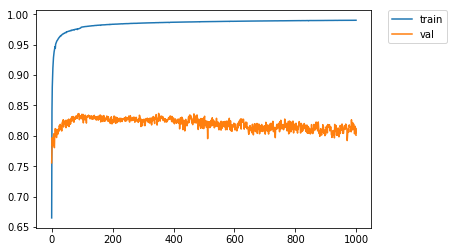

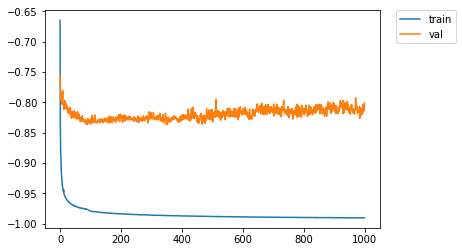

In [9]:
csv_history_file = "dataset/dataset-1/testenh-1.csv"
data = {}

with open(csv_history_file, "r") as f:
    reader = csv.reader(f, delimiter=";")
    for i, line in enumerate(reader):
        if i > 0:
            IOU_calc_in_csv, acc_in_csv, dice_coef_accur_in_csv, f1_score_in_csv, loss_in_csv, val_IOU_calc_in_csv, val_acc_in_csv, val_dice_coef_accur_in_csv, val_f1_score_in_csv, val_loss_in_csv = float(line[1]), float(line[2]), float(line[3]), float(line[4]), float(line[5]), float(line[6]), float(line[7]), float(line[8]), float(line[9]), float(line[10])
            dice_coef_accur_list = data.get('dice_coef_accur', None)
            if dice_coef_accur_list is None:
                dice_coef_accur_list = [dice_coef_accur_in_csv]
                data['dice_coef_accur'] = dice_coef_accur_list
            else:
                data['dice_coef_accur'].append(dice_coef_accur_in_csv)
                

            loss_list = data.get('loss', None)
            if loss_list is None:
                loss_list = [loss_in_csv]
                data['loss'] = loss_list
            else:
                data['loss'].append(loss_in_csv)
                
            val_dice_coef_accur_list = data.get('val_dice_coef_accur', None)
            if val_dice_coef_accur_list is None:
                val_dice_coef_accur_list = [val_dice_coef_accur_in_csv]
                data['val_dice_coef_accur'] = val_dice_coef_accur_list
            else:
                data['val_dice_coef_accur'].append(val_dice_coef_accur_in_csv)
            
            val_loss_list = data.get('val_loss', None)
            if val_loss_list is None:
                val_loss_list = [val_loss_in_csv]
                data['val_loss'] = val_loss_list
            else:
                data['val_loss'].append(val_loss_in_csv)

x = data['dice_coef_accur']
y = data['val_dice_coef_accur']
plt.plot(x, label='train')
plt.plot(y, label = 'val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

x = data['loss']
y = data['val_loss']
plt.plot(x, label='train')
plt.plot(y, label='val')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Evaluate the model

In [10]:
# test_loss, accuracy_test = model.evaluate(Xte, yte, verbose=1)
print("Training Accuracy Mean: "+str(np.array(data['dice_coef_accur']).mean()))
print("Validation Accuracy Mean: "+str(np.array(data['val_dice_coef_accur']).mean()))
# print("Test Accuracy Mean: "+str(accuracy_test))
score = model.evaluate(Xte, yte, verbose=1)
print(model.metrics_names)
print(score)

Training Accuracy Mean: 0.9846880800994056
Validation Accuracy Mean: 0.8194728783244041
412/412 [==============================] - 5s 12ms/step
['loss', 'acc', 'dice_coef_accur', 'IOU_calc', 'f1_score']
[-0.8573805701385424, 0.9769038216581623, 0.8573805701385424, 0.866309566405213, 0.8662926496811283]


### Predict masks using the trained model

In [11]:
# model.load_weights("dataset/dataset-1/test-3-02-0.7472.hdf5")
# model.load_weights("dataset/dataset-1/test-4-01-0.6881.hdf5")
# model.load_weights("dataset/dataset-1/test-5-10-0.9667.hdf5")
# model.load_weights("dataset/dataset-1/test-6-91-0.9785.hdf5")
# model.load_weights("dataset/dataset-1/test-7-58-0.9767.hdf5")
# model.load_weights("dataset/dataset-1/test-8-10-0.9800.hdf5")
# model.load_weights("dataset/dataset-1/test-9-07-0.9618.hdf5")
# model.load_weights("dataset/dataset-1/test-10-912-0.8516.hdf5")
# model.load_weights("dataset/dataset-1/test-11-572-0.8587.hdf5")
# model.load_weights("dataset/dataset-1/test-12-846-0.8519.hdf5")
# model.load_weights("dataset/dataset-1/test-13-312-0.8595.hdf5")
model.load_weights("dataset/dataset-1/testenh-1-352-0.8370.hdf5")
# test_loss, accuracy_test, a, b, c = model.evaluate(Xte, yte, verbose=0)
# print("Test Accuracy Mean: "+str(accuracy_test))
score = model.evaluate(Xte, yte, verbose=1)
print(model.metrics_names)
print(score)
imgs_mask_test = model.predict(Xte, verbose=1)

412/412 [==============================] - 1s 2ms/step
['loss', 'acc', 'dice_coef_accur', 'IOU_calc', 'f1_score']
[-0.8573805701385424, 0.9769038216581623, 0.8573805701385424, 0.866309566405213, 0.8662926496811283]
412/412 [==============================] - 1s 3ms/step


### Show results

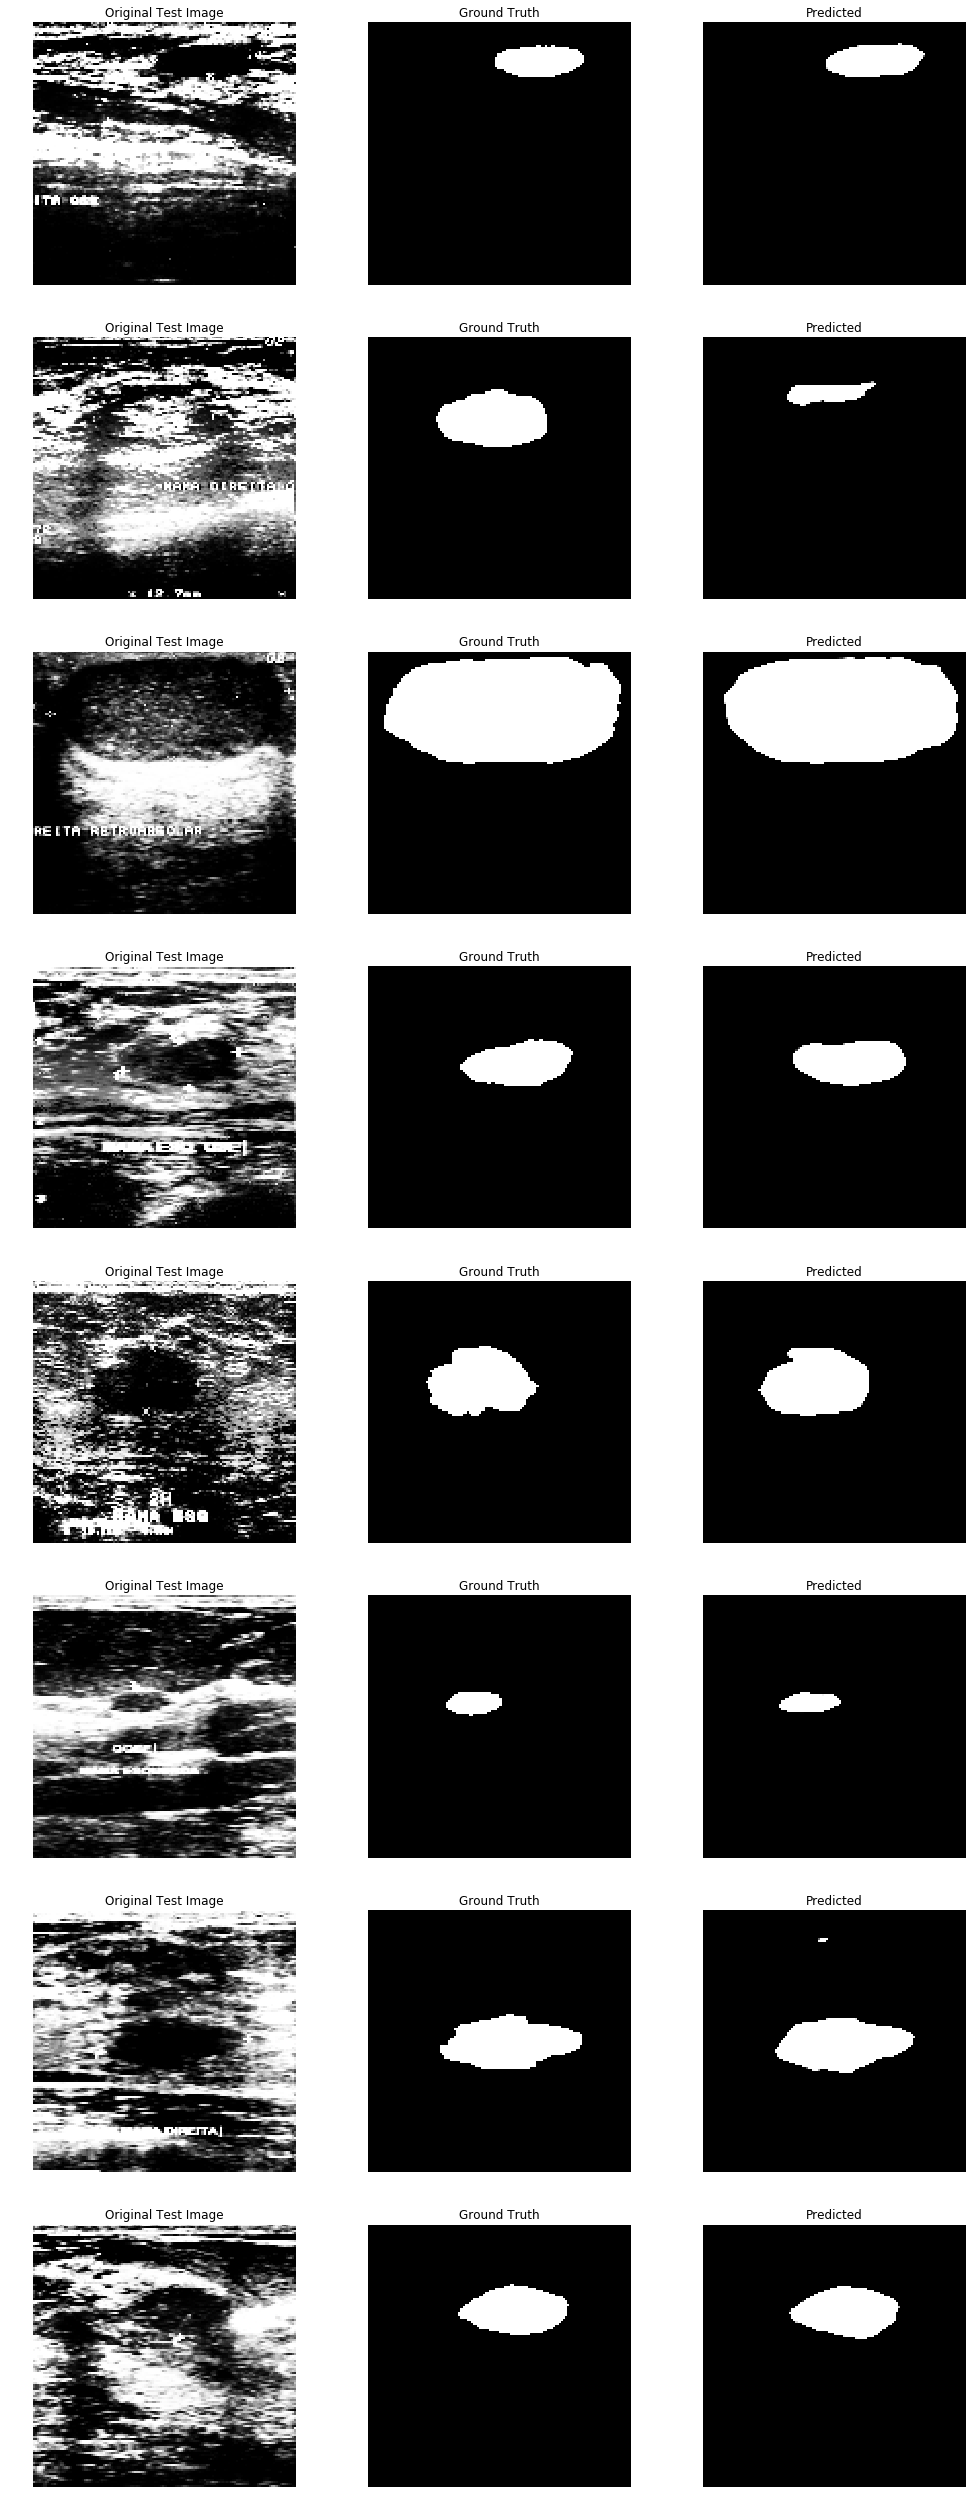

In [12]:
ncols = 3 # number of columns in final grid of images
nrows = 8 # looking at all images takes some time
_, axes = plt.subplots(nrows, ncols, figsize=(17, 17*nrows/ncols))
for axis in axes.flatten():
    axis.set_axis_off()
    axis.set_aspect('equal')

for k in range(0, nrows):
    im_test_original = Xte[k].reshape(*input_image_shape)
    im_result = imgs_mask_test[k].reshape(*input_image_shape)
    im_ground_truth = yte[k].reshape(*input_image_shape)
    
    axes[k, 0].set_title("Original Test Image")
    axes[k, 0].imshow(im_test_original, cmap='gray')
    
    axes[k, 1].set_title("Ground Truth")
    axes[k, 1].imshow(im_ground_truth, cmap='gray')
    
    axes[k, 2].set_title("Predicted")
    axes[k, 2].imshow(im_result, cmap='gray')

### Save predicted images to disk

In [13]:
total_images, width, height, _ = imgs_mask_test.shape

for i in range(total_images):
    I = imgs_mask_test[i].reshape(width, height)
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
    img = Image.fromarray(I8)
    img.save(result_imgs_folder.format(i, 'predicted'))
    
    I = yte[i].reshape(width, height)
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
    img = Image.fromarray(I8)
    img.save(result_imgs_folder.format(i, 'gt'))

/home/pedrodeoliveirav/miniconda3/envs/cc/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


### Compare images quality

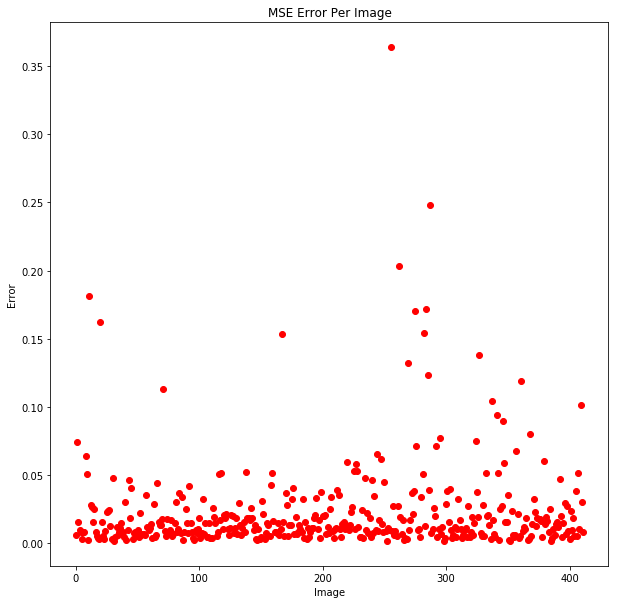

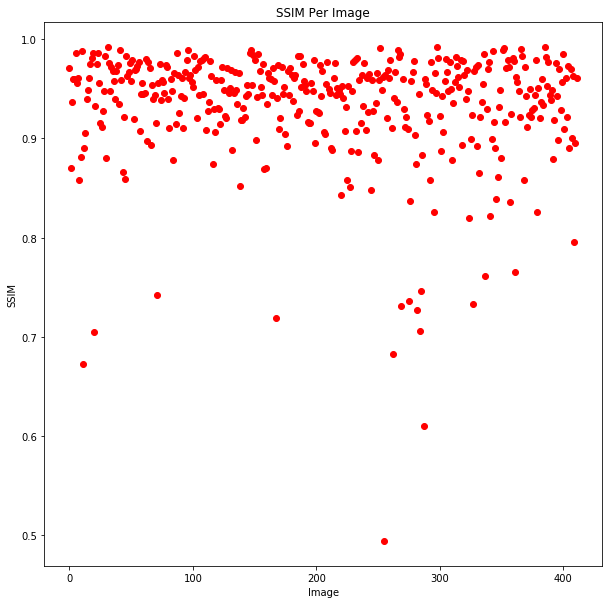

In [14]:
def mse(ground_truth, predicted):
    _, width, height, _ = ground_truth.shape
    return np.sum(( (predicted - ground_truth) ** 2), axis=(1,2,3)) / (width * height)

result = mse(imgs_mask_test, yte)

objects = tuple([x for x in range(yte.shape[0])])
y_pos = np.arange(len(objects))
 
plt.figure(figsize=(10, 10))
plt.plot(y_pos, result, 'ro')
#plt.bar(y_pos, result)
plt.ylabel('Error')
plt.xlabel('Image')
plt.title('MSE Error Per Image')
 
plt.show()

number_of_images, width, height, _ = yte.shape
objects = []
result = []
for i in range(number_of_images):
    objects.append(i)
    ground_truth = yte[i].astype('float32').reshape(yte.shape[1:3])
    predicted = imgs_mask_test[i].reshape(imgs_mask_test.shape[1:3])
    result.append(ssim(ground_truth, predicted))
    
objects = tuple(objects)
y_pos = np.arange(len(objects))
 
plt.figure(figsize=(10, 10))
plt.plot(y_pos, result, 'ro')
#plt.bar(y_pos, result)
plt.ylabel('SSIM')
plt.xlabel('Image')
plt.title('SSIM Per Image')
 
plt.show()

Values lower than 0.001 = []
Their indices are  (array([], dtype=int64),)
0
0.02301888210081657 0.0350012651792651


{'whiskers': [<matplotlib.lines.Line2D at 0x7f40b01d5198>,
 'caps': [<matplotlib.lines.Line2D at 0x7f40b01d5828>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f40b01d5048>],
 'medians': [<matplotlib.lines.Line2D at 0x7f40b01d5eb8>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f40b01db240>],
 'means': []}

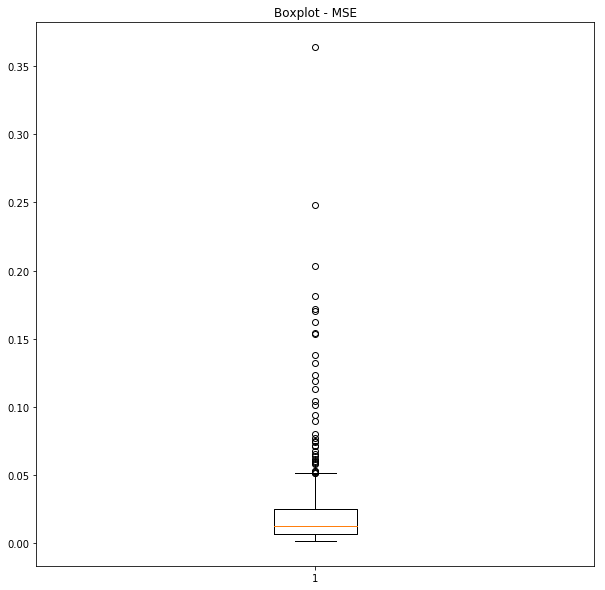

In [15]:
x = mse(imgs_mask_test, yte)
print("Values lower than 0.001 =", x[x<0.001])
print("Their indices are ", np.nonzero(x<0.001))
print(len(x[x<0.001]))
print(x.mean(), x.std())

# ncols = 3 # number of columns in final grid of images
# nrows = 1 # looking at all images takes some time
# _, axes = plt.subplots(nrows, ncols, figsize=(17, 17*nrows/ncols))
# for axis in axes.flatten():
#     axis.set_axis_off()
#     axis.set_aspect('equal')

# k=375
# im_test_original = Xte[k].reshape(*input_image_shape)
# im_result = imgs_mask_test[k].reshape(*input_image_shape)
# im_ground_truth = yte[k].reshape(*input_image_shape)
    
# axes[0].set_title("Original Test Image")
# axes[0].imshow(im_test_original, cmap='gray')
    
# axes[1].set_title("Ground Truth")
# axes[1].imshow(im_ground_truth, cmap='gray')
# axes[2].set_title("Predicted")
# axes[2].imshow(im_result, cmap='gray')

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.set_title('Boxplot - MSE')
ax1.boxplot(x)

### Compare image quality results of all tests

In [16]:
def _setup_regularizers(conv_layer, use_regularizers):
    return BatchNormalization()(conv_layer) if use_regularizers else conv_layer
    
def _setup_dropout(conv_layer, use_dropout):
    return Dropout(dropout_rate)(conv_layer) if use_dropout else conv_layer

def get_model_prelu(kernel_size, use_regularizer, use_dropout, initial_volume_size, LOSS):
    from keras.layers.advanced_activations import PReLU
    inputs = Input((*input_image_shape, 1))
    conv1 = Conv2D(initial_volume_size, kernel_size, padding='same')(inputs)
    conv1 = PReLU()(conv1)
    conv1 = Conv2D(initial_volume_size, kernel_size, padding='same')(conv1)
    conv1 = PReLU()(conv1)
    conv1 = setup_regularizers(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(initial_volume_size*2, kernel_size, padding='same')(pool1)
    conv2 = PReLU()(conv2)
    conv2 = Conv2D(initial_volume_size*2, kernel_size, padding='same')(conv2)
    conv2 = PReLU()(conv2)
    conv2 = setup_regularizers(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(initial_volume_size*4, kernel_size, padding='same')(pool2)
    conv3 = PReLU()(conv3)
    conv3 = Conv2D(initial_volume_size*4, kernel_size, padding='same')(conv3)
    conv3 = PReLU()(conv3)
    conv3 = setup_regularizers(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(initial_volume_size*8, kernel_size, padding='same')(pool3)
    conv4 = PReLU()(conv4)
    conv4 = Conv2D(initial_volume_size*8, kernel_size, padding='same')(conv4)
    conv4 = PReLU()(conv4)
    conv4 = setup_regularizers(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(initial_volume_size*16, kernel_size, padding='same')(pool4)
    conv5 = PReLU()(conv5)
    conv5 = Conv2D(initial_volume_size*16, kernel_size, padding='same')(conv5)
    conv5 = PReLU()(conv5)
    conv5 = setup_regularizers(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    up6 = setup_dropout(up6)
    conv6 = Conv2D(initial_volume_size*8, kernel_size, padding='same')(up6)
    conv6 = PReLU()(conv6)
    conv6 = Conv2D(initial_volume_size*8, kernel_size, padding='same')(conv6)
    conv6 = PReLU()(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    up7 = setup_dropout(up7)
    conv7 = Conv2D(initial_volume_size*4, kernel_size, padding='same')(up7)
    conv7 = PReLU()(conv7)
    conv7 = Conv2D(initial_volume_size*4, kernel_size, padding='same')(conv7)
    conv7 = PReLU()(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    up8 = setup_dropout(up8)
    conv8 = Conv2D(initial_volume_size*2, kernel_size, padding='same')(up8)
    conv8 = PReLU()(conv8)
    conv8 = Conv2D(initial_volume_size*2, kernel_size, padding='same')(conv8)
    conv8 = PReLU()(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    up9 = setup_dropout(up9)
    conv9 = Conv2D(initial_volume_size, kernel_size, padding='same')(up9)
    conv9 = PReLU()(conv9)
    conv9 = Conv2D(initial_volume_size, kernel_size, padding='same')(conv9)
    conv9 = PReLU()(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9) #sigmoid/softmax

    model.compile(optimizer=Adam(lr=1e-5), loss=LOSS, metrics=[dice_coef_accur])
    return model

def get_model(kernel_size, use_regularizer, use_dropout, initial_volume_size, LOSS):
    # Define model
    inputs = Input((*input_image_shape, 1))
    conv1 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(conv1)
    conv1 = _setup_regularizers(conv1, use_regularizer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(conv2)
    conv2 = _setup_regularizers(conv2, use_regularizer)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(conv3)
    conv3 = _setup_regularizers(conv3, use_regularizer)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(conv4)
    conv4 = _setup_regularizers(conv4, use_regularizer)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(initial_volume_size*16, kernel_size, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(initial_volume_size*16, kernel_size, activation='relu', padding='same')(conv5)
    conv5 = _setup_regularizers(conv5, use_regularizer)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    up6 = _setup_dropout(up6, use_dropout)
    conv6 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(up6)
    conv6 = Conv2D(initial_volume_size*8, kernel_size, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    up7 = _setup_dropout(up7, use_dropout)
    conv7 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(up7)
    conv7 = Conv2D(initial_volume_size*4, kernel_size, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    up8 = _setup_dropout(up8, use_dropout)
    conv8 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(up8)
    conv8 = Conv2D(initial_volume_size*2, kernel_size, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    up9 = _setup_dropout(up9, use_dropout)
    conv9 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(up9)
    conv9 = Conv2D(initial_volume_size, kernel_size, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=LOSS, metrics=[dice_coef_accur])
    return model
    

In [17]:
trained_models = [
    #("datasets/dataset-1/test-1.hdf5", get_model((3,3), False, False, 32)),
    #("datasets/dataset-1/test-2-996--0.9361-0.9361.hdf5", get_model((3,3), False, False, 32)),
    #("datasets/dataset-1/test-3-97-0.9321.hdf5", get_model((3,3), False, False, 32)),
    #("datasets/dataset-1/test-4-new-tentative-02-0.9494.hdf5", get_model((3,3), False, False, 32)),
    #("datasets/dataset-1/test-5-new-tentative-682-0.9783.hdf5", get_model((3,3), True, True, 32)),
    #("datasets/dataset-1/test-6-144-0.9554.hdf5", get_model((5,5), True, True, 64)),
    #("datasets/dataset-1/test-6-new-tentative-105-0.9527.hdf5", get_model((5,5), True, True, 64))
    ##
    #("dataset/dataset-1/test-3-02-0.7472.hdf5",get_model((3,3), False, False, 32))
    #("dataset/dataset-1/test-3-02-0.7472.hdf5",get_model((3,3), False, False, 64))
#     ("dataset/dataset-1/test-3-02-0.7472.hdf5",get_model((3,3), True, True, 64))
    #("dataset/dataset-1/test-3-02-0.7472.hdf5",get_model((5,5), False, False, 32))
#     ("dataset/dataset-1/test-10-912-0.8516.hdf5",get_model((3,3), True, True, 64))
#     ("dataset/dataset-1/test-11-572-0.8587.hdf5",get_model((3,3), True, True, 64))
#     ("dataset/dataset-1/test-12-846-0.8519.hdf5",get_model_prelu((3,3), True, True, 64,'binary_crossentropy'))
#     ("dataset/dataset-1/test-13-312-0.8595.hdf5",get_model_prelu((3,3), True, True, 64, dice_coef_loss))
     ("dataset/dataset-1/testenh-1-352-0.8370.hdf5",get_model((3,3), True, True, 64))
   
]

def dice_coef_numpy(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = 2 * np.sum(y_true_f * y_pred_f) + smooth
    union = np.sum(y_true_f) + np.sum(y_pred_f) + smooth
    return np.mean(intersection / union)

def _get_predicitions_for_model(trained_model):
    weights, model = trained_model
    model.load_weights(weights)
    imgs_mask_test = model.predict(Xte, verbose=1)
    return imgs_mask_test

def get_box_data_for_each_model(comparison_function):
    data = []
    for model_prediction in models_predictions: 
        result = []
        for i in range(number_of_images):
            ground_truth = yte[i].astype('float32').reshape(yte.shape[1:3])
            predicted = model_prediction[i].reshape(imgs_mask_test.shape[1:3])
            measure = comparison_function(ground_truth, predicted)
            result.append(measure)
        data.append(result)
    return data

def _create_box_plot(data, fig_identifier, subplot_index):
    # Create a figure instance
    fig = plt.figure(fig_identifier, figsize=(18, 12))

    # Create an axes instance
    ax = fig.add_subplot(subplot_index)

    # Create the boxplot
    bp = ax.boxplot(data, patch_artist=True)

    for box in bp['boxes']:
        # change outline color
        box.set( color='#000000', linewidth=2)
        # change fill color
        box.set( facecolor = 'pink' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='#000000', linewidth=2)

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='#000000', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='#ff0000', linewidth=2)

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='green')


models_predictions = []
for trained_model in trained_models:
    models_predictions.append(_get_predicitions_for_model(trained_model))

TypeError: get_model() missing 1 required positional argument: 'LOSS'

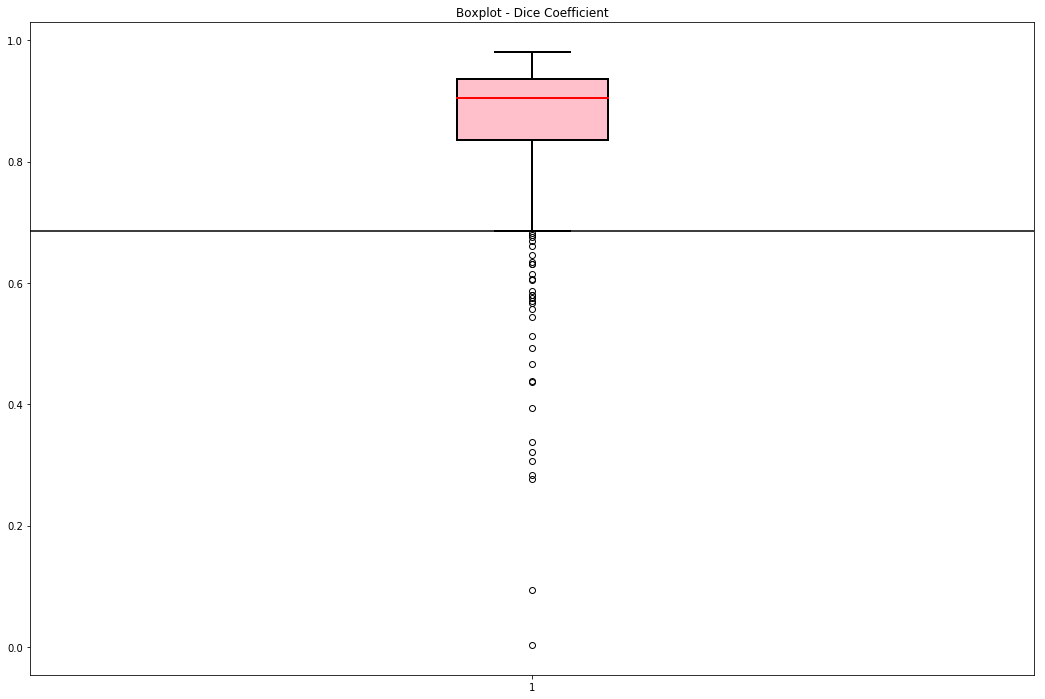

0.8585333086846834 0.13242638252987016


In [50]:
data = get_box_data_for_each_model(dice_coef_numpy)
_create_box_plot(data, 'dice', 111)
plt.axhline(y=0.685, color='k', linestyle='-') #linha de apoio
plt.title('Boxplot - Dice Coefficient')
plt.show()

def flatten(x):
    result = []
    for el in x:
        if hasattr(el, "__iter__") and not isinstance(el, str):
            result.extend(flatten(el))
        else:
            result.append(el)
    return result

dice = (flatten(data))
dicearray = np.asarray(dice)
print(dicearray.mean(), dicearray.std())

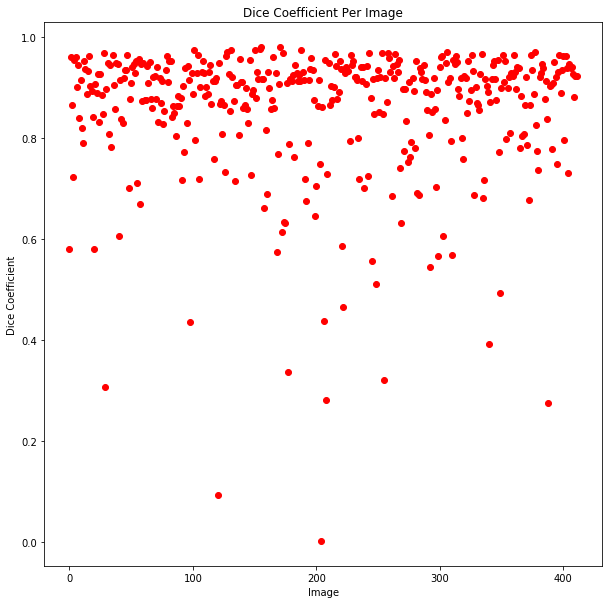

Outliers = [0.58041304 0.58022987 0.30700425 0.60691683 0.668914   0.4359467
 0.09396594 0.66080294 0.5744503  0.61449319 0.6344644  0.63159007
 0.33716579 0.6757233  0.64621471 0.00276243 0.43823034 0.28245971
 0.58641285 0.46665612 0.55646628 0.51203585 0.32171193 0.63178744
 0.54422326 0.56715684 0.60550308 0.56959003 0.68226731 0.39324766
 0.4929939  0.67842535 0.27645716]
Their indices are  (array([  0,  20,  29,  40,  57,  98, 120, 158, 168, 172, 174, 175, 177,
       192, 199, 204, 206, 208, 221, 222, 245, 248, 255, 269, 292, 299,
       303, 310, 335, 340, 349, 372, 388]),)
33
0.8585333086846834 0.13242638252987016


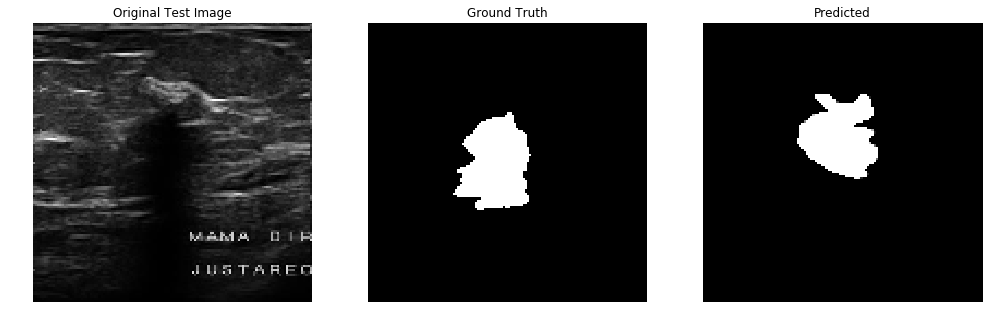

In [53]:
result = dicearray

objects = tuple([x for x in range(yte.shape[0])])
y_pos = np.arange(len(objects))
 
plt.figure(figsize=(10, 10))
# plt.axhline(y=0.685, color='k', linestyle='-') #linha de apoio
plt.plot(y_pos, result, 'ro')
plt.ylabel('Dice Coefficient')
plt.xlabel('Image')
plt.title('Dice Coefficient Per Image')
 
plt.show()

x = result
print("Outliers =", x[x<=0.685])
print("Their indices are ", np.nonzero(x<=0.685))
print(len(x[x<=0.685]))
print(x.mean(), x.std())

ncols = 3 # number of columns in final grid of images
nrows = 1 # looking at all images takes some time
_, axes = plt.subplots(nrows, ncols, figsize=(17, 17*nrows/ncols))
for axis in axes.flatten():
    axis.set_axis_off()
    axis.set_aspect('equal')

outliers= [20,  29,  33,  40,  48,  55,  57,  89,  91,  93,  95,  98, 117,
       126, 158, 168, 169, 172, 174, 175, 177, 182, 192, 203, 204, 206,
       208, 222, 235, 239, 245, 248, 254, 255, 269, 292, 299, 310, 328, 
        335, 336, 340, 358, 367, 372, 379, 385, 388]
k=20
im_test_original = Xte[k].reshape(*input_image_shape)
im_result = imgs_mask_test[k].reshape(*input_image_shape)
im_ground_truth = yte[k].reshape(*input_image_shape) 
axes[0].set_title("Original Test Image")
axes[0].imshow(im_test_original, cmap='gray')
axes[1].set_title("Ground Truth")
axes[1].imshow(im_ground_truth, cmap='gray')
axes[2].set_title("Predicted")
axes[2].imshow(im_result, cmap='gray')

In [54]:
#Salvando Outliers
outliers =  [  20,  29,  30,  40,  48,  55,  57,  95,  98, 126, 158, 168, 172,
       174, 175, 177, 192, 199, 204, 206, 208, 235, 239, 245, 255, 261,
       269, 276, 280, 283, 299, 310, 335, 340, 348, 349, 367, 388, 404]
result_imgs_folder = 'results/outliers-13/{}_{}.tiff'
total_images, width, height, _ = imgs_mask_test.shape
for i in outliers:
#     I = imgs_mask_test[i].reshape(width, height)
#     I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
#     img = Image.fromarray(I8)
#     img.save(result_imgs_folder.format(i, 'predicted'))
    
#     I = yte[i].reshape(width, height)
#     I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
#     img = Image.fromarray(I8)
#     img.save(result_imgs_folder.format(i, 'gt'))
    
    I = Xte[i].reshape(*input_image_shape)
    I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
    img = Image.fromarray(I8)
    img.save(result_imgs_folder.format(i, 'original'))

/home/pedrodeoliveirav/miniconda3/envs/cc/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


### Segmenting isolated image

In [34]:
path = "datasets/dataset-1/tests-random-images"
images_in_disk = os.listdir(path)
print(images_in_disk)
img_size = (128, 128)
images = np.array([])
number_of_images_total = 0

for f in images_in_disk[8:]:
    input_image_location = os.path.join(path,f)
    if os.path.isfile(input_image_location):
        print(input_image_location)
        input_image = Image.open(input_image_location, 'r').convert('L').resize(img_size)
        input_image_array = np.array(input_image)

        images = np.append(images, input_image_array)
        number_of_images_total += 1

images = images.reshape(number_of_images_total, *img_size, 1)
images = (images - full_image_mean_value) / full_image_sd

segmented_images = model.predict(images, verbose=1)

ncols = 2 # number of columns in final grid of images
nrows = number_of_images_total # looking at all images takes some time
_, axes = plt.subplots(nrows, ncols, figsize=(17, 17*nrows/ncols))
for axis in axes.flatten():
    axis.set_axis_off()
    axis.set_aspect('equal')

for k in range(0, nrows):
    im_original = images[k].reshape(*img_size)
    im_result = segmented_images[k].reshape(*img_size)
    
    axes[k, 0].set_title("Original Image: {}".format(images_in_disk[k]))
    axes[k, 0].imshow(im_original, cmap='gray')
    
    axes[k, 1].set_title("Segmented")
    axes[k, 1].imshow(im_result, cmap='gray')

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/dataset-1/tests-random-images'

['e8b196f5268ae6dc7f6915cbb48c88_big_gallery.jpeg', '7.gif', 'brain-mri.jpg', 'mri-aera-neurology-00042957_10.jpg', 'services-procedure-mri.png', '1.jpg', '2.jpg', '57b8c9597eca6af263751452cac585_big_gallery.jpeg', '8ad53e454a5a04f3ceab61820cbff7_gallery.jpg', '225598357_2f9c1268d7.jpg', 'brain-scan-611x600.jpg', '006T1MRI.jpg', 'MRI_brain.jpg', 'scan.jpg']
datasets/dataset-1/tests-random-images/e8b196f5268ae6dc7f6915cbb48c88_big_gallery.jpeg
datasets/dataset-1/tests-random-images/7.gif
datasets/dataset-1/tests-random-images/brain-mri.jpg
datasets/dataset-1/tests-random-images/mri-aera-neurology-00042957_10.jpg
datasets/dataset-1/tests-random-images/services-procedure-mri.png
datasets/dataset-1/tests-random-images/1.jpg
datasets/dataset-1/tests-random-images/2.jpg
datasets/dataset-1/tests-random-images/57b8c9597eca6af263751452cac585_big_gallery.jpeg
datasets/dataset-1/tests-random-images/8ad53e454a5a04f3ceab61820cbff7_gallery.jpg
datasets/dataset-1/tests-random-images/225598357_2f9c126

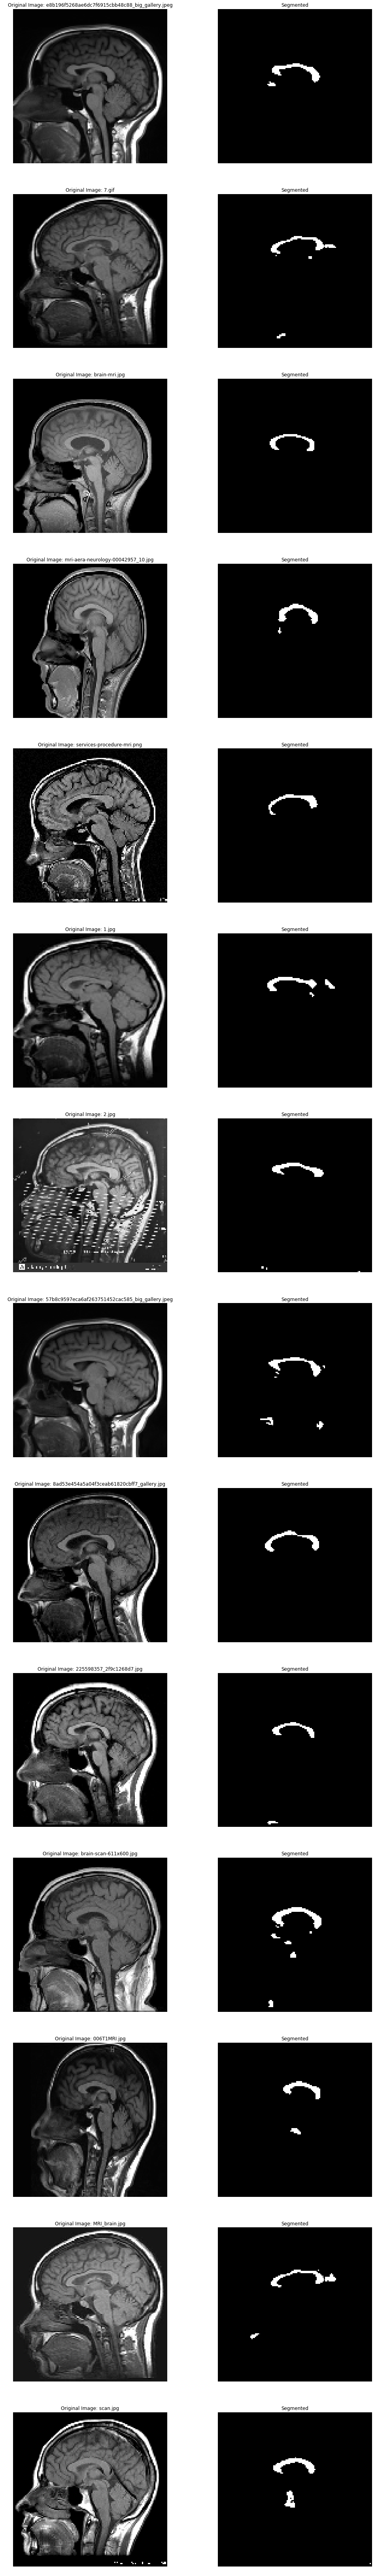

In [61]:
path = "datasets/dataset-1/tests-random-images"
images_in_disk = os.listdir(path)
print(images_in_disk)
img_size = (128, 128)
images = np.array([])
number_of_images_total = 0

for f in images_in_disk:
    input_image_location = os.path.join(path,f)
    if os.path.isfile(input_image_location):
        print(input_image_location)
        input_image = Image.open(input_image_location, 'r').convert('L').resize(img_size)
        input_image_array = np.array(input_image)

        images = np.append(images, input_image_array)
        number_of_images_total += 1

images = images.reshape(number_of_images_total, *img_size, 1)
images = (images - full_image_mean_value) / full_image_sd

segmented_images = model.predict(images, verbose=1)

ncols = 2 # number of columns in final grid of images
nrows = number_of_images_total # looking at all images takes some time
_, axes = plt.subplots(nrows, ncols, figsize=(17, 17*nrows/ncols))
for axis in axes.flatten():
    axis.set_axis_off()
    axis.set_aspect('equal')

for k in range(0, nrows):
    im_original = images[k].reshape(*img_size)
    im_result = segmented_images[k].reshape(*img_size)
    
    axes[k, 0].set_title("Original Image: {}".format(images_in_disk[k]))
    axes[k, 0].imshow(im_original, cmap='gray')
    
    axes[k, 1].set_title("Segmented")
    axes[k, 1].imshow(im_result, cmap='gray')

### Fun Experiment: Looking at the layers!

In [35]:
def _get_convolutions(layer_name):
    output = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None][0]
    inputs = [K.learning_phase()] + model.inputs
    _convout1_f = K.function(inputs, [output])
    def convout1_f(X):
        # The [0] is to disable the training phase flag
        return _convout1_f([0] + [X])
    
    convolutions = convout1_f(Xte[0:1])
    convolutions = np.squeeze(convolutions)
    return convolutions


def layer_to_visualize(layer_name, save_plot=False):
    convolutions = _get_convolutions(layer_name)
    #print ('Shape of conv:', convolutions.shape)

    n = convolutions.shape[0]
    
    from math import sqrt
    ncols = nrows = int(sqrt(convolutions.shape[2])) # board
    fig, axes = plt.subplots(nrows, ncols, figsize=(80, 80*nrows/ncols))
    for axis in axes.flatten():
        axis.set_axis_off()
        axis.set_aspect('equal')
    
    for k in range(0, nrows):
        for j in range(0, ncols):
            axes[k, j].imshow(convolutions[:,:,k*nrows+j], cmap='gray')
    if save_plot:
        fig.savefig(layer_name)


"""layers_name = ['conv2d_136', 'conv2d_137', 'batch_normalization_17', 'max_pooling2d_29', 
               'conv2d_138', 'conv2d_139', 'batch_normalization_18', 'max_pooling2d_30', 'conv2d_140', 
               'conv2d_141', 'batch_normalization_19', 'max_pooling2d_31', 'conv2d_142', 'conv2d_143', 
               'batch_normalization_20', 'max_pooling2d_32', 'conv2d_144', 'conv2d_145', 
               'batch_normalization_21', 'up_sampling2d_29', 'concatenate_29', 'dropout_13', 'conv2d_146', 
               'conv2d_147', 'up_sampling2d_30', 'concatenate_30', 'dropout_14', 'conv2d_148', 'conv2d_149', 
               'up_sampling2d_31', 'concatenate_31', 'dropout_15', 'conv2d_150', 'conv2d_151', 'up_sampling2d_32', 
               'concatenate_32', 'dropout_16', 'conv2d_152', 'conv2d_153', 'conv2d_154']"""

layers_name = [layer.name for layer in model.layers]
print(layers_name)

#for layer in layers_name:
    # Specify the layer to want to visualize
layer_to_visualize(layer_name='conv2d_37', save_plot=False)

#a = get_activations(model, imgs_mask_test[0:1], print_shape_only=True)  # with just one sample.
#display_activations(a)

['input_1', 'conv2d_1', 'conv2d_2', 'batch_normalization_1', 'max_pooling2d_1', 'conv2d_3', 'conv2d_4', 'batch_normalization_2', 'max_pooling2d_2', 'conv2d_5', 'conv2d_6', 'batch_normalization_3', 'max_pooling2d_3', 'conv2d_7', 'conv2d_8', 'batch_normalization_4', 'max_pooling2d_4', 'conv2d_9', 'conv2d_10', 'batch_normalization_5', 'up_sampling2d_1', 'concatenate_1', 'dropout_1', 'conv2d_11', 'conv2d_12', 'up_sampling2d_2', 'concatenate_2', 'dropout_2', 'conv2d_13', 'conv2d_14', 'up_sampling2d_3', 'concatenate_3', 'dropout_3', 'conv2d_15', 'conv2d_16', 'up_sampling2d_4', 'concatenate_4', 'dropout_4', 'conv2d_17', 'conv2d_18', 'conv2d_19']


IndexError: list index out of range

### Fun Experiment 2: Looking at Layers using PCA

(128, 128, 32)


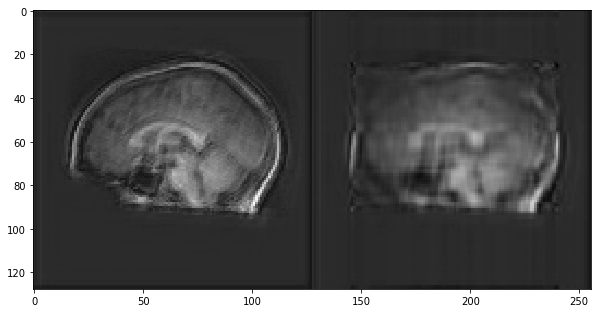

In [102]:
def side_by_side(indexes):
    org = Xtr[indexes].reshape(28,28)
    rec = inv_sc[indexes].reshape(28,28)
    pair = np.concatenate((org, rec), axis=1)
    plt.figure(figsize=(4,2))
    plt.imshow(pair)
    plt.show()
    
#for index in range(0,10):
    #side_by_side(index)

convs = _get_convolutions(layer_name='conv2d_37')
print(convs.shape)
    
pca = PCA(n_components=7)
test = convs[:,:,20]
pca_result = pca.fit_transform(test)

inv_pca = pca.inverse_transform(pca_result)

pair = np.concatenate((test, inv_pca), axis=1)
plt.figure(figsize=(10,10))
plt.imshow(pair, cmap='gray')
plt.show()

